# Comedy Rating Prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import model_selection as cv
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
# from IPython.dispaly import Image
from tqdm import tqdm_notebook 
from collections import Counter
from math import sqrt
import warnings

plt.style.use('seaborn')
%matplotlib inline
%config InlineBackend.figure_format  = 'retina'
warnings.filterwarnings
plt.rcParams['figure.figsize'] = [10,5]

<h1  style="font-size: 20px">**Loading Your data**<h1>

<span style="font-size:15px">Make sure to change the file reference as this notebook was developed locally. The dataset can be found here <a href="https://www.kaggle.com/c/dsn2018selection/data">Comedy Data.</a><span>

## Training Data
com_df = pd.read_csv('C:/Users/Training/Desktop/comedy data/train.csv')

In [4]:
com_df.head(10)

,Viewers_ID,Joke_identifier,Response_ID,Rating
0,A1,Klint De Drunk Enugu 1,A1_Klint De Drunk Enugu 1,0.11
1,A1,Klint De Drunk Enugu 2,A1_Klint De Drunk Enugu 2,-4.64
2,A1,Klint De Drunk PH 1,A1_Klint De Drunk PH 1,-3.39
3,A1,Klint De Drunk PH 2,A1_Klint De Drunk PH 2,0.44
4,A1,Klint De Drunk Lagos 1,A1_Klint De Drunk Lagos 1,-4.83
5,A1,Klint De Drunk Lagos 2,A1_Klint De Drunk Lagos 2,-4.52
6,A1,Klint De Drunk Lagos 3,A1_Klint De Drunk Lagos 3,-3.73
7,A1,Klint De Drunk Warri 1,A1_Klint De Drunk Warri 1,-4.36
8,A1,AliBaba Lagos 2,A1_AliBaba Lagos 2,-4.39
9,A1,AliBaba Aso Rock 2,A1_AliBaba Aso Rock 2,4.39


<span  style="font-size: 15px">Let us know the number of unique users and the number of shows rated in the train dataset<span> 

In [5]:
no_users_tr = len(set(com_df.Viewers_ID))
no_jokes_tr = len(set(com_df.Joke_identifier))
print('The number of unique users are {0} and the number of unique comedy shows are {1} in train data'.format(no_users_tr,
                                                                                                           no_jokes_tr))

The number of unique users are 40863 and the number of unique comedy shows are 127 in train data


In [7]:
#load the test data set
com_df_test = pd.read_csv('C:/Users/Training/Desktop/comedy data/test.csv')

<span  style="font-size: 15px">let us also know the number of unique users and the number of shows rated in the test dataset. It might be that there are some comdey shows in the train not in the test and vice versa<span>

In [8]:
no_users_te = len(set(com_df_test.Viewers_ID))
no_jokes_te = len(set(com_df_test.Joke_identifier))
print('The number of unique users are {0} and the number of unique comedy shows are {1} in test data'.format(no_users_te, 
                                                                                                             no_jokes_te))

The number of unique users are 40863 and the number of unique comedy shows are 135 in test data


In [9]:
#let us know if there are some jokes in train not in test
common = list(set(com_df.Joke_identifier) & set(com_df_test.Joke_identifier))

print("There are {0} comedy shows common to both train and test".format(len(common)))

There are 123 comedy shows common to both train and test


In [10]:
#let us also figure out jokes that are not are in train but not in test and vice versa

notIntest = [jk for jk in tqdm_notebook(list(set(com_df.Joke_identifier))) if jk not in list(set(com_df_test.Joke_identifier))]
notIntrain = [jk for jk in tqdm_notebook(list(set(com_df_test.Joke_identifier))) if jk not in list(set(com_df.Joke_identifier))]

tot_jokes = len(set(list(com_df_test.Joke_identifier) + list(com_df.Joke_identifier)))
print('There are {0} comedy shows in train not in test and {1} comedy shows in test not in train'.format(len(notIntest),
                                                                                                         len(notIntrain)))
print('There are also {0} unique comedy shows in both train and test'.format(tot_jokes))

A Jupyter Widget

A Jupyter Widget


There are 4 comedy shows in train not in test and 12 comedy shows in test not in train
There are also 139 unique comedy shows in both train and test


<h1  style="font-size: 20px">let us create a dictionary with a unique mapping for all the users and the comedy shows<h1>

In [11]:
users_dict = {}
uniq_id = 0
for uza in sorted(list(set(com_df.Viewers_ID))):
    users_dict[uza] = uniq_id
    uniq_id += 1
    
com_dict = {}
c_id = 0
for comd in sorted(list(set(list(com_df_test.Joke_identifier) + list(com_df.Joke_identifier)))):
    com_dict[comd] = c_id
    c_id += 1

<h1 style="font-size: 20px">First Attempt with Stochastisc Gradient Descent<h1>

<span style="font-size:15px">Let us try explicit rating using Stochastic gradient descent optimization algorithm.  According to this paper <a href="http://proceedings.mlr.press/v36/li14.pdf">Link here.</a> The SGD can be implemeted by first randomly intialising the user item feature matrices and making updates to the matrices until the error between the dot product of the user-tem matrices and the Real matrix R is minimized.
The objective function is given as follows:
 \begin{equation*}
  min_{P,Q} \sum_{u,v} (r_{u,v} - p_{u}q_{v}^T)^2 + \lambda_{P}||P_{u}||^2 + \lambda_{Q}||q_{v}||^2
\end{equation*}
    where u,v is for each user and item entry.
    <span>
    <span style="font-size:18px">
   The idea is to update the user-item matrices multiple times using two rules:
    \begin{equation*}
  p_{u}  = p_{u} + \gamma((r_{u,v} - p_{u}q_{v}^T)q_{v} -  \lambda_{P}p_{u})
  \end{equation*}
   \begin{equation*}
  q_{u}  = q_{u} + \gamma((r_{u,v} - p_{u}q_{v}^T)p_{u} -  \lambda_{Q}q_{u})
\end{equation*}
<span>

<span style="font-size:15px">Let us initialise our parameters and user item feature matrices<span>

In [12]:
# create two user-item matrices, one for the train dataset and the other for the test dataset
train_mat = np.zeros((no_users_tr, tot_jokes))
for line in com_df.itertuples():
    train_mat[users_dict[line[1]], com_dict[line[2]]] = line[4]

In [13]:
train_data, test_data = cv.train_test_split(train_mat, test_size=0.2)

In [14]:
train_data.shape

(32690, 139)

In [15]:
lmbda = 0.4 # Regularization weight
k = 20  # Dimensionality of the latent feature space
m, n = train_data.shape  # Number of users and items
iterations = 30  # Number of epochs
gamma =0.005  # Learning rate
 
user_feature = 3 * np.random.rand(k,m) # Latent user feature matrix
movie_feature = 3 * np.random.rand(k,n) # Latent movie feature matrix

<span style="font-size:15px">Only consider non-zero users and items which means items rated only by users<span>

In [16]:
%%time
users,items = train_data.nonzero()
for iter in range(iterations):
    for u, i in zip(users,items):
        error = train_data[u, i] - np.dot(user_feature[:,u].T,movie_feature[:,i])  # Calculate error for gradient
        user_feature[:,u] += gamma * (error * movie_feature[:,i] - lmbda * user_feature[:,u]) # Update latent user feature matrix
        movie_feature[:,i] += gamma * (error * user_feature[:,u] - lmbda * movie_feature[:,i])  # Update latent movie feature matrix

Wall time: 7min 48s


<span style="font-size:15px">Let us come up with metrics to measure our performace. But before we proceed let us keep it at the back of our mind that this algorithm might not be the best choice for production because it takes about 5mins to train.<span>

<h2 style="font-size:18px">RMSE metric definition<h2>

In [17]:
from sklearn.metrics import mean_squared_error
def rt_mean_sqrd(y_true, y_pred):
    
    return np.sqrt(mean_squared_error(y_true[y_true.nonzero()].flatten(), y_pred[y_true.nonzero()].flatten()))

In [18]:
prediction_SGD = np.dot(user_feature.T, movie_feature)

In [19]:
print('Train RMSE for SGD is {0}'.format(rt_mean_sqrd(train_data, prediction_SGD)))

Train RMSE for SGD is 2.244429697091997


In [20]:
print('Test RMSE for SGD is {0}'.format(rt_mean_sqrd(test_data, prediction_SGD)))

Test RMSE for SGD is 2.7420247588288404


<span style="font-size:15px">Let us increase the number of iterations. This will obviously take more time but let us see if this will improve the model performance.<span>

In [21]:
%%time
lmbda = 0.4 # Regularization weight
k = 20  # Dimensionality of the latent feature space
m, n = train_data.shape  # Number of users and items
iterations = 100  # Number of epochs
gamma =0.005  # Learning rate
 
user_feature = 3 * np.random.rand(k,m) # Latent user feature matrix
movie_feature = 3 * np.random.rand(k,n) # Latent movie feature matrix



users,items = train_data.nonzero()
for iter in range(iterations):
    for u, i in zip(users,items):
        error = train_data[u, i] - np.dot(user_feature[:,u].T,movie_feature[:,i])  # Calculate error for gradient
        user_feature[:,u] += gamma * (error * movie_feature[:,i] - lmbda * user_feature[:,u]) # Update latent user feature matrix
        movie_feature[:,i] += gamma * (error * user_feature[:,u] - lmbda * movie_feature[:,i])  # Update latent movie feature matrix


prediction_SGD = np.dot(user_feature.T, movie_feature)
print('Train RMSE for SGD is {0}'.format(rt_mean_sqrd(train_data, prediction_SGD)))
print('Test RMSE for SGD is {0}'.format(rt_mean_sqrd(test_data, prediction_SGD)))

Train RMSE for SGD is 2.0421897823876765
Test RMSE for SGD is 2.7707397776013125
Wall time: 26min 8s


<span style="font-size:15px">At this point we can say that SGD algorithm over-fits. However, we could play with other paramters such as the regularization parameter and learning rate to improve model performance.<span>

<h3> Using Singular Value Decomposition(SVD)<h3>

<span style="font-size:15px">SVD is a form of Matrix Decomposition into new matrices that can help us understand our original matrix better. 
It contains information that are not obvious in the original matrix format. It is a form of matrix factorization that factorizes the original matrix into 3 matrices. One major advantage of SVD over other decomposition algorithms like eigen decomposiiton is that all matrices can be decomposed into singular values and singular vectors.<span>

<img src="http://mblogthumb3.phinf.naver.net/MjAxODAxMDJfMjQ3/MDAxNTE0ODQ4MjI3MDMy.Mcpq16rhbeEVUaDpJ_IhOVtFTSvEtErSadPbwtj1E5Eg.DKSqS63UupNG5-GkYuiKfLCist1-byhv_eMyluSRaCIg.PNG.car9380/image.png?type=w800">

<span style="font-size:15px">For a user-item matrix, the matrix can be decomposed into left singular-vectors that carry information about the users called latent factors while the right-singular vector matrix contains information about the items. The diagonal matrix in the middle records the information of the decomposition. They are eigen values. Eigen values are just scalars.<span>

<h3>Let us implement SVD using well known Surpise Library in Python<h3>

In [23]:
from surprise import SVD
from surprise import Dataset

<span style="font-size:15px">Replace the user ids and joke ids with the unique ids generated previously<span>

In [24]:
new_df = pd.DataFrame()
new_df['user_id'] = [users_dict[v_id] for v_id in com_df.Viewers_ID]
new_df['item_id'] = [com_dict[j_id] for j_id in com_df.Joke_identifier]
new_df['rating'] = com_df.Rating

In [25]:
new_df.head(6)

,user_id,item_id,rating
0,0,96,0.11
1,0,97,-4.64
2,0,102,-3.39
3,0,103,0.44
4,0,99,-4.83
5,0,100,-4.52


In [26]:
from surprise import Reader
reader = Reader(rating_scale=(-5, 5)) #specifies the scale of the ratings

data = Dataset.load_from_df(new_df[['user_id', 'item_id', 'rating']], reader)
trainset = data.build_full_trainset()

<span style="font-size: 15px">let us run a small grid search to select best hyperparameters while we are implementing the SVD algorithm<span>

In [27]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [50], 'lr_all':[0.005,0.007],
              'reg_all': [0.2,0.4]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=1)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.6min finished


2.146800573950489
{'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.2}
Wall time: 7min 37s


<span style="font-size:15px">This is a much better performance from SVD from the surprise package. It appears not to overfitt and a grid search of 5 parameters space with 50 epochs ran much faster than SGD based algorithm.<span>

<span style="font-size:15px">Recently Deep learning algorithms have been besting machine learning algorithms at so many tasks. Most notably image recognition, text classification and so on. It will only suffice for us to implement a deep learning model using keras to attempt to improve model performance.<span>

<h3>Deep Learning Model Implementation Using Keras<h3>

<span style="font-size:15px">let us split the train data now into train and test splits so when training we can use a 
portion of the train data for validation<span>

In [43]:
from sklearn.model_selection import train_test_split
train_nw, test_nw = train_test_split(new_df, test_size=0.2)

In [44]:
train_nw.head()

,user_id,item_id,rating
15007,1048,0,2.64
316408,20976,40,0.69
231850,15569,98,0.55
412757,26969,97,-1.42
466574,30594,99,-2.98


<span style="font-size:15px">We can employ an encoder-decoder architecture. The encoder is a form of matrix decomposition that compresses the matrix into low-dimensional space with new learnt features. The decoder step decodes the matrix into the original matrix R. The closer the learnt matrix to its original matrix the better<span>

In [35]:
import tensorflow as tf
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_jokes = no_users_tr, tot_jokes
n_latent_factors = 20 

In [33]:
from keras.layers import Input,Embedding,Dense,Reshape, Dropout
from keras import Model

In [59]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 8
user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=n_jokes,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

input_vecs = keras.layers.Concatenate()([user_vecs, item_vecs])
input_vecs = Dropout(0.25)(input_vecs)

enc_x1 = Dense(128, activation='relu')(input_vecs)
enc_x2= Dense(64, activation='relu')(enc_x1)
enc_x3 = Dense(32, activation='relu')(enc_x2)
enc_x4 = Dense(16, activation='relu')(enc_x3)

latent = Dense(8, activation='relu')(enc_x3)

dec_layer1 = Dense(16, activation='relu')(latent)
dec_layer2 = Dense(32, activation='relu')(dec_layer1)
dec_layer3 = Dense(64, activation='relu')(dec_layer2)
dec_layer4 = Dense(128, activation='relu')(dec_layer3)

x = Dropout(0.25)(dec_layer4)
# x = Dense(128, activation='relu')(x)
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
from keras import optimizers
c = optimizers.adam(lr = 0.0005, decay=1e-6)
model.compile(optimizer=c, loss='mse')  

In [60]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         326904      user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         1112        item[0][0]                       
__________________________________________________________________________________________________
reshape_9 

In [39]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [61]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('C:/Users/Training/Desktop/comedy data/model/Recommend_DL.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1)

In [62]:
history = model.fit([train_nw.user_id, train_nw.item_id], train_nw.rating, callbacks=[earlystopper, checkpointer,reduce_lr],
          validation_split=0.1, batch_size = 128, epochs=7, verbose=2) 

Train on 441144 samples, validate on 49017 samples
Epoch 1/7
Epoch 00001: val_loss improved from inf to 4.95768, saving model to C:/Users/Training/Desktop/comedy data/model/Recommend_DL.h5
 - 29s - loss: 5.6240 - val_loss: 4.9577
Epoch 2/7
Epoch 00002: val_loss improved from 4.95768 to 4.79236, saving model to C:/Users/Training/Desktop/comedy data/model/Recommend_DL.h5
 - 31s - loss: 4.7483 - val_loss: 4.7924
Epoch 3/7
Epoch 00003: val_loss improved from 4.79236 to 4.73372, saving model to C:/Users/Training/Desktop/comedy data/model/Recommend_DL.h5
 - 28s - loss: 4.4872 - val_loss: 4.7337
Epoch 4/7
Epoch 00004: val_loss improved from 4.73372 to 4.71088, saving model to C:/Users/Training/Desktop/comedy data/model/Recommend_DL.h5
 - 27s - loss: 4.2851 - val_loss: 4.7109
Epoch 5/7
Epoch 00005: val_loss did not improve
 - 27s - loss: 4.1339 - val_loss: 4.7130
Epoch 6/7
Epoch 00006: val_loss improved from 4.71088 to 4.71013, saving model to C:/Users/Training/Desktop/comedy data/model/Recomm

In [63]:
%matplotlib inline
import math
import matplotlib.pyplot as plt

(1.8, 2.5)

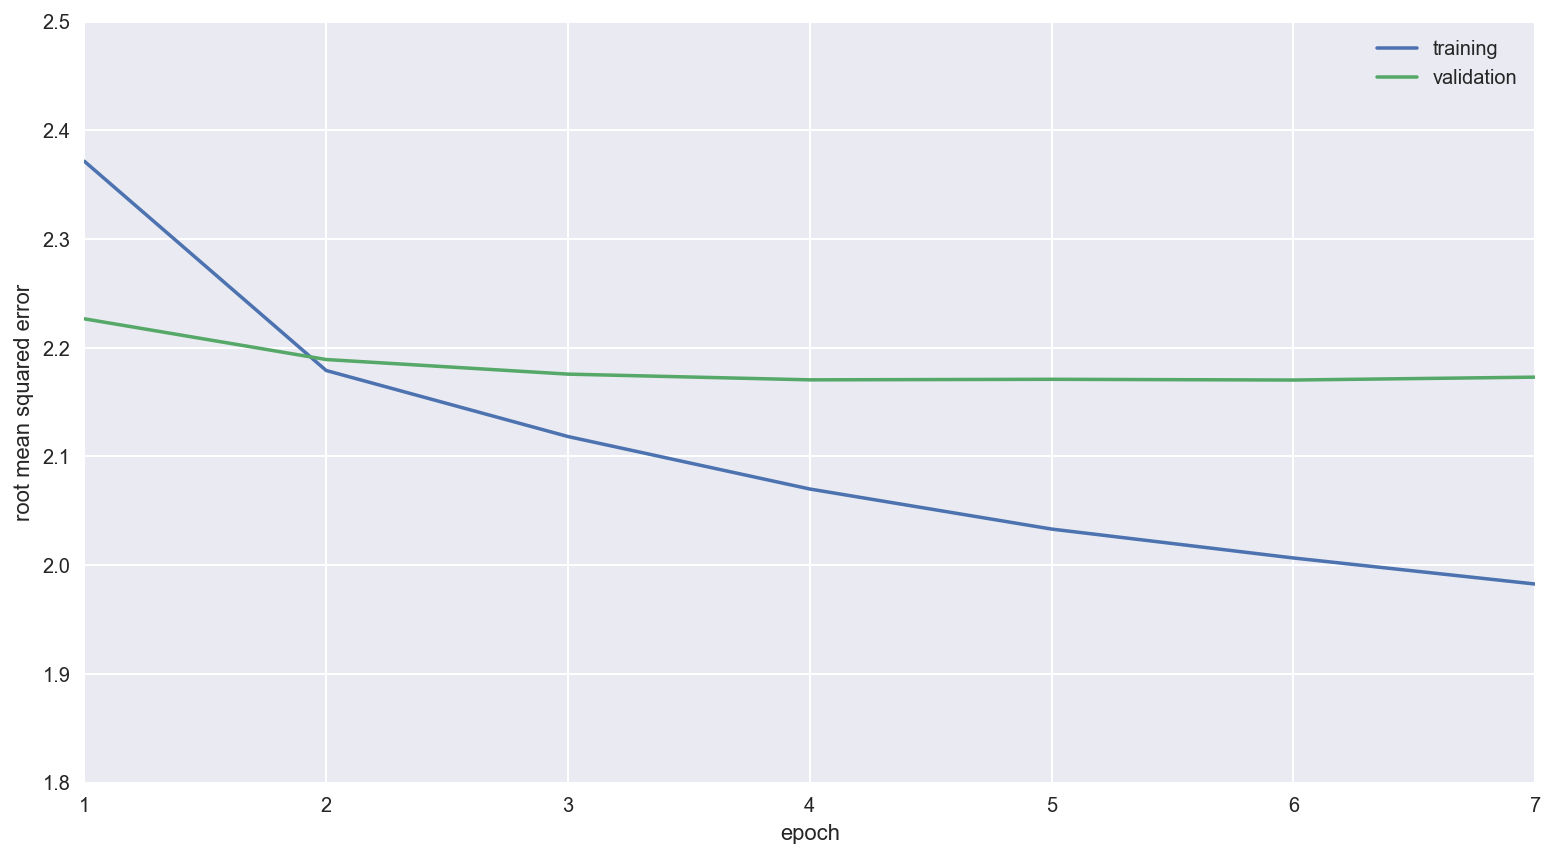

In [75]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
ax = loss.iloc[:,:].plot(x='epoch', figsize=(13,7), grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([1.8,2.5])

In [65]:
from keras.models import Model, load_model

In [66]:
learnt = load_model('C:/Users/Training/Desktop/comedy data/model/Recommend_DL.h5')

In [69]:
y_hat = learnt.predict([test_nw.user_id, test_nw.item_id])
y_true = test_nw.rating

In [76]:
from sklearn.metrics import mean_squared_error
print('Train RMSE for Encoder-Decoder is {0}'.format(np.sqrt(mean_squared_error(y_true, y_hat))))

Train RMSE for Encoder-Decoder is 2.1706804147555623


## In Conclusion

One can see that SVD from surprise outperforms SGD-based predictor and Deep learning model. Further exploration to improve the model performance can begin by first looking at the dataset. Some comedy shows in the test data are not represented well in the train data hence the models built so far did not come across such items during training. A balance of the dataset can be done to reflect all items in both train and test set. 
Other algorithms like KNNBaseline, NMF or SVD++ in the surprise package can be experimented with to improve model performance. <a href = "http://surpriselib.com/">Link here</a>
The deep learning approach can be experimented with the most. One can choose a different architecture from the encoder-decoder architecture used.The best algorithm would have to be robust, an algorithm that does not overfit.